## Testing a new attempt to integrate Tobin's classification with radar data

Combine Tobin with Steiner and see if the results still make sense on the scales of radar data.

In [8]:
import pyart
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
%matplotlib inline
import time
from copy import deepcopy
import math
import scipy

## Test case 1 - MCS Dec 24 2005 13Z

In [5]:
radar_mcs_path = '/home/rjackson/data/radar/cpol/Gunn_pt_20051224130000ppi.nc'
radar_mcs = pyart.io.read(radar_mcs_path)

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in sqrt
/home/rjackson/.local/lib/python3.5/site-packages/pyart/filters/gatefilter.py:444: RuntimeWarning: invalid value encountered in greater
  marked = self._get_fdata(field) > value


0.3304779529571533


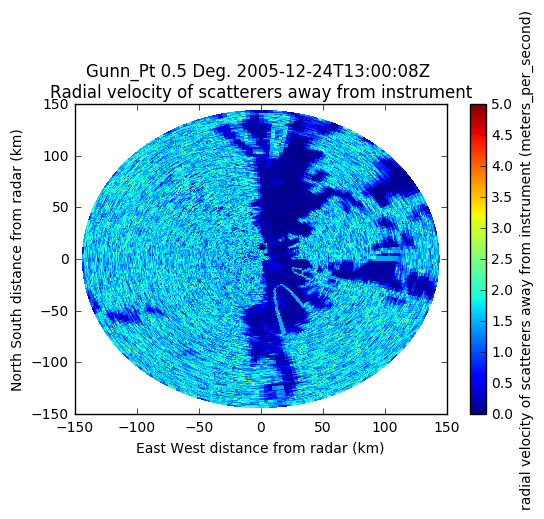

In [47]:
gatefilter = pyart.filters.GateFilter(radar_mcs)
#gatefilter.exclude_below('cross_correlation_ratio', 0.5)
#gatefilter.exclude_below('reflectivity',0)
display_mcs = pyart.graph.RadarMapDisplay(radar_mcs)
nyq_Gunn = radar_mcs.instrument_parameters['nyquist_velocity']['data'][0]
bt = time.time()
#data = ndimage.filters.generic_filter(radar_mcs.fields['velocity']['data'],
#                                      pyart.util.interval_std, size = (3,3),
#                                      extra_arguments = (-nyq_Gunn, nyq_Gunn))
#filtered_data = ndimage.filters.median_filter(data, size = (3,3))
filtered_data = std_convoluted_radar(radar_mcs.fields['velocity']['data'], 1, (-nyq_Gunn, nyq_Gunn))
texture_field = pyart.config.get_metadata('velocity')
texture_field['data'] = filtered_data
texture = texture_field['data']
radar_mcs.add_field('velocity_texture', texture_field, replace_existing = True)  
print(time.time()-bt)
gatefilter.exclude_above('velocity_texture', 3)
display_mcs.plot_ppi('velocity_texture',  gatefilter=gatefilter, vmin=0, vmax=5)

In [45]:
def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000), bsp=1.0, 
               min_radius=750, h_factor=4.0, nb=1.5,
               fields=['DT', 'VT'], origin=None, gatefilter=None):
    bt = time.time()
    radar_list = [radar]
    if origin is None:
        origin = (radar.latitude['data'][0],
                  radar.longitude['data'][0])
    grid = pyart.map.grid_from_radars(
        radar_list, grid_shape=grid_shape,
        grid_limits=(zlim, ylim, xlim),
        grid_origin=origin, fields=fields,
        weighting_function='Cressman',
        gridding_algo='map_gates_to_grid',
        h_factor=h_factor,
        min_radius=min_radius,
        bsp=bsp,
        nb=nb,
        gatefilter=gatefilter)
    print(time.time() - bt, 'seconds to grid radar')
    return grid

# Use convolutions to calculate angular texture
def std_convoluted_radar(image, N, interval):
    # transform distribution from original interval to [-pi, pi]
    interval_max = interval[1]
    interval_min = interval[0]
    half_width = (interval_max - interval_min) / 2.
    center = interval_min + half_width
    
    # Calculate parameters needed for angular std. dev
    a = (np.asarray(image) - center) / (half_width) * np.pi
    im = a
    x = np.cos(im)
    y = np.sin(im)

    x2 = x**2
    y2 = y**2
    ones = np.ones(x.shape)
    
    # Calculate convolution
    kernel = np.ones((2*N+1, 2*N+1))
    xs = scipy.signal.convolve2d(x, kernel, mode="same")
    ys = scipy.signal.convolve2d(y, kernel, mode="same")
    ns = scipy.signal.convolve2d(ones, kernel, mode="same")
    
    # Calculate norm over specified window
    xmean = xs/ns
    ymean = ys/ns
    norm = np.sqrt(xmean**2 + ymean**2)
    return np.sqrt(-2 * np.log(norm))

In [67]:
grid_mcs = grid_radar(radar_mcs, 
                      origin=(radar_mcs.latitude['data'][0], radar_mcs.longitude['data'][0]),
                      xlim=(-150000, 150000), ylim=(-150000, 150000), 
                      fields=['reflectivity', 'velocity_texture'], min_radius=500.0, bsp=1.0, nb=1.0,
                      h_factor=1.0,
                      zlim=(500, 20000), grid_shape=(40, 151, 151),
                      gatefilter=gatefilter)

0.7584109306335449 seconds to grid radar


N = 31
0.09376788139343262 seconds to grid radar


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


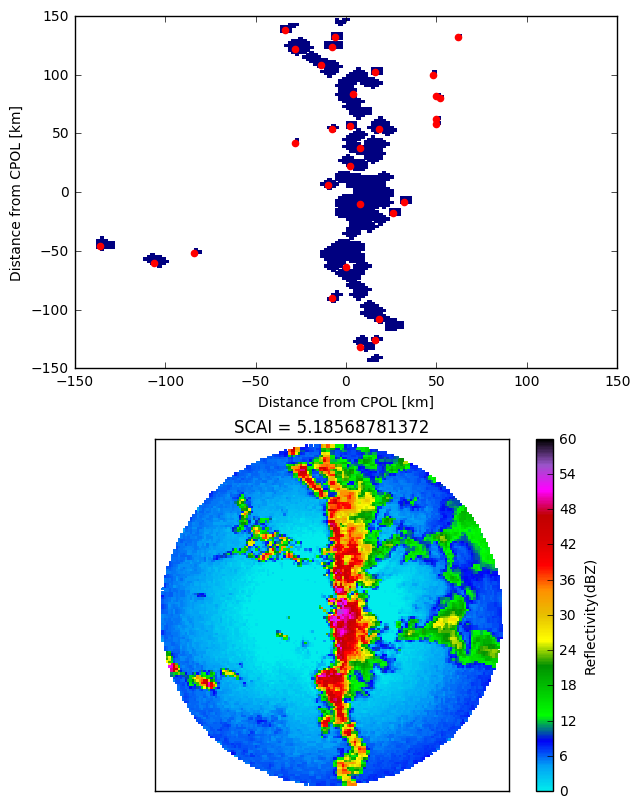

In [69]:
bt = time.time()
convective = pyart.retrieve.steiner_conv_strat(grid_mcs,
                                               work_level=3500,
                                               )
x,y = np.meshgrid(grid_mcs.x['data'], grid_mcs.y['data'])

data_masked = np.ma.masked_where(convective['data'] < 2, convective['data'])
blobs = deepcopy(data_masked)
blobs[~blobs.mask] = 1
blobs[blobs.mask] = 0
blobs.mask = False

# Get locations of blobs

blobs_labels, num_blobs = ndimage.measurements.label(blobs)
print('N = ' + str(num_blobs-2))
locs = ndimage.measurements.center_of_mass(blobs, blobs_labels, range(2, num_blobs))
List = [(elem2, elem1) for elem1, elem2 in locs]
x_points = []
y_points = []
for element in List:  
    x_points.append(x[element[1], element[0]]/1e3)
    y_points.append(y[element[1], element[0]]/1e3)
print(time.time() - bt, 'seconds to grid radar')
plt.figure(figsize=(7,10))
plt.subplot(211)
plt.pcolormesh(x/1e3,y/1e3,data_masked)
plt.xlabel('Distance from CPOL [km]')
plt.ylabel('Distance from CPOL [km]')
plt.scatter(x_points, y_points, color='r')
plt.xlim([-150,150])
plt.ylim([-150,150])
plt.subplot(212)
grid_display = pyart.graph.GridMapDisplay(grid_mcs)
grid_display.plot_grid('reflectivity', level=1, vmin=0, vmax=60)

L = 150.0
a = 1
Nmax = pow((L/a),2)

distances = []
for point1 in List:
    for point2 in List:
        if(point1 != point2):
            d = math.sqrt(pow(point1[0]-point2[0],2) + pow(point1[1]-point2[1],2))
            distances.append(d)
            
n = (num_blobs-2)*(num_blobs-3)/2
d1 = 1/float(n)*np.sum(distances*5)
scai = ((num_blobs-2))/Nmax*d1/(L)*1000
plt.title('SCAI = ' + str(scai))

## Test case 2 - March 5 2006 (disorganized) 1210Z

In [ ]:
radar_dis_path = '/home/rjackson/data/radar/cpol/Gunn_pt_20060305121000ppi.nc'
radar_dis = pyart.io.read(radar_dis_path)

In [ ]:
gatefilter = pyart.filters.GateFilter(radar_dis)
gatefilter.exclude_below('cross_correlation_ratio', 0.5)
gatefilter.exclude_below('reflectivity',10)
display_dis = pyart.graph.RadarMapDisplay(radar_dis)
display_dis.plot_ppi('reflectivity',  gatefilter=gatefilter)

In [ ]:
grid_dis = grid_radar(radar_dis, 
                      origin=(radar_mcs.latitude['data'][0], radar_mcs.longitude['data'][0]),
                      xlim=(-150000, 150000), ylim=(-150000, 150000), 
                      fields=['reflectivity'], min_radius=750.0, bsp=1.0, nb=1.5,
                      h_factor=2.0,
                      zlim=(500, 20000), grid_shape=(40, 121, 121),
                      gatefilter=gatefilter)

In [ ]:
convective = pyart.retrieve.steiner_conv_strat(grid_dis)
x,y = np.meshgrid(grid_dis.x['data'], grid_dis.y['data'])

data_masked = np.ma.masked_where(convective['data'] < 2, convective['data'])
blobs = deepcopy(data_masked)
blobs[~blobs.mask] = 1
blobs[blobs.mask] = 0
blobs.mask = False

# Get locations of blobs

blobs_labels, num_blobs = ndimage.measurements.label(blobs)
print('N = ' + str(num_blobs-2))
locs = ndimage.measurements.center_of_mass(blobs, blobs_labels, range(2, num_blobs))
List = [(elem2, elem1) for elem1, elem2 in locs]
x_points = []
y_points = []
for element in List:  
    x_points.append(x[element[1], element[0]]/1e3)
    y_points.append(y[element[1], element[0]]/1e3)
plt.pcolormesh(x/1e3,y/1e3,data_masked)
plt.xlabel('Distance from CPOL [km]')
plt.ylabel('Distance from CPOL [km]')
plt.scatter(x_points, y_points, color='r')
L = 150.0
a = 1
Nmax = pow((L/a),2)

distances = []
for point1 in List:
    for point2 in List:
        if(point1 != point2):
            d = math.sqrt(pow(point1[0]-point2[0],2) + pow(point1[1]-point2[1],2))
            distances.append(d)
            
n = (num_blobs-2)*(num_blobs-3)/2
d1 = 1/float(n)*np.sum(distances*5)
scai = ((num_blobs-2))/Nmax*d1/(L)*1000
plt.title('SCAI = ' + str(scai))

## Test case 3 - Two lines + few cells 2-4-2007 550Z

In [9]:
radar_ns_path = '/home/rjackson/data/radar/cpol/Gunn_pt_20070204055000ppi.nc'
radar_ns = pyart.io.read(radar_ns_path)

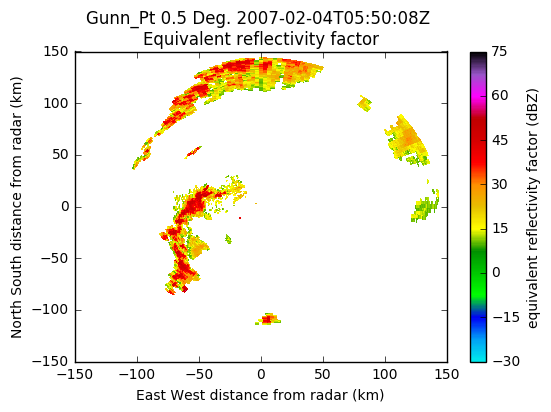

In [15]:
gatefilter = pyart.filters.GateFilter(radar_ns)
gatefilter.exclude_below('cross_correlation_ratio', 0.5)
gatefilter.exclude_below('reflectivity',10)
nyq_Gunn = radar_ns.instrument_parameters['nyquist_velocity']['data'][0]

data = ndimage.filters.generic_filter(radar_ns.fields['velocity']['data'],
                                      pyart.util.interval_std, size = (6,6),
                                      extra_arguments = (-nyq_Gunn, nyq_Gunn))
filtered_data = ndimage.filters.median_filter(data, size = (4,4))
texture_field = pyart.config.get_metadata('velocity')
texture_field['data'] = filtered_data
texture = texture_field['data']
radar_ns.add_field('velocity_texture', texture_field, replace_existing = True)    
gatefilter.exclude_above('velocity_texture', 4)
display_ns = pyart.graph.RadarMapDisplay(radar_ns)
display_ns.plot_ppi('reflectivity',  gatefilter=gatefilter)

In [16]:
grid_ns = grid_radar(radar_ns, 
                     origin=(radar_mcs.latitude['data'][0], radar_mcs.longitude['data'][0]),
                     xlim=(-150000, 150000), ylim=(-150000, 150000), 
                     fields=['reflectivity'], min_radius=750.0, bsp=1.0, nb=1.5,
                     h_factor=2.0,
                     zlim=(500, 20000), grid_shape=(40, 121, 121),
                     gatefilter=gatefilter)

2.6095995903015137 seconds to grid radar


N = 24


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


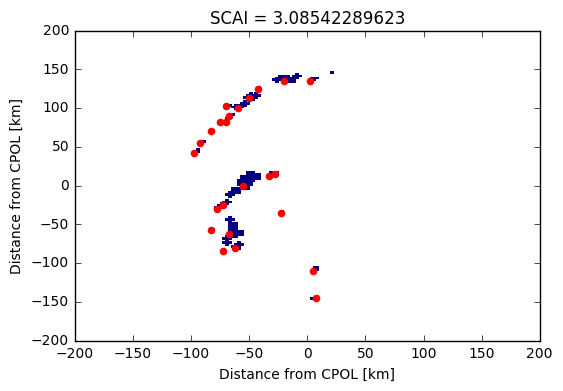

In [17]:
convective = pyart.retrieve.steiner_conv_strat(grid_ns)
x,y = np.meshgrid(grid_ns.x['data'], grid_ns.y['data'])

data_masked = np.ma.masked_where(convective['data'] < 2, convective['data'])
blobs = deepcopy(data_masked)
blobs[~blobs.mask] = 1
blobs[blobs.mask] = 0
blobs.mask = False

# Get locations of blobs

blobs_labels, num_blobs = ndimage.measurements.label(blobs)
print('N = ' + str(num_blobs-2))
locs = ndimage.measurements.center_of_mass(blobs, blobs_labels, range(2, num_blobs))
List = [(elem2, elem1) for elem1, elem2 in locs]
x_points = []
y_points = []
for element in List:  
    x_points.append(x[element[1], element[0]]/1e3)
    y_points.append(y[element[1], element[0]]/1e3)
plt.pcolormesh(x/1e3,y/1e3,data_masked)
plt.xlabel('Distance from CPOL [km]')
plt.ylabel('Distance from CPOL [km]')
plt.scatter(x_points, y_points, color='r')
L = 150.0
a = 1
Nmax = pow((L/a),2)

distances = []
for point1 in List:
    for point2 in List:
        if(point1 != point2):
            d = math.sqrt(pow(point1[0]-point2[0],2) + pow(point1[1]-point2[1],2))
            distances.append(d)
            
n = (num_blobs-2)*(num_blobs-3)/2
d1 = 1/float(n)*np.sum(distances*5)
scai = ((num_blobs-2))/Nmax*d1/(L)*1000
plt.title('SCAI = ' + str(scai))

## March 24 2007 420Z -- scattered showers

In [18]:
radar_ss_path = '/home/rjackson/data/radar/cpol/Gunn_pt_20070324042000ppi.nc'
radar_ss = pyart.io.read(radar_ss_path)

44.59726119041443 second to filter data


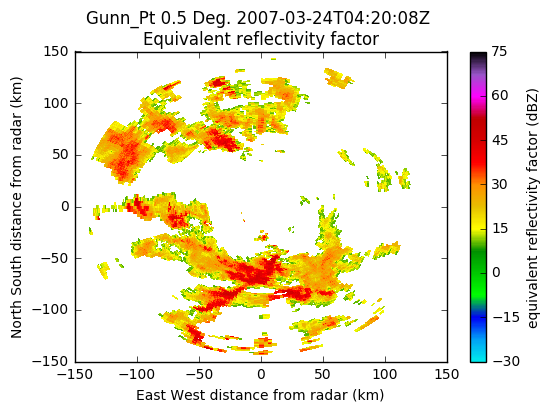

In [23]:
gatefilter = pyart.filters.GateFilter(radar_ss)
gatefilter.exclude_below('cross_correlation_ratio', 0.5)
nyq_Gunn = radar_ss.instrument_parameters['nyquist_velocity']['data'][0]
bt = time.time()
data = ndimage.filters.generic_filter(radar_ss.fields['velocity']['data'],
                                      pyart.util.interval_std, size = (6,6),
                                      extra_arguments = (-nyq_Gunn, nyq_Gunn))
filtered_data = ndimage.filters.median_filter(data, size = (4,4))
texture_field = pyart.config.get_metadata('velocity')
texture_field['data'] = filtered_data
texture = texture_field['data']
radar_ss.add_field('velocity_texture', texture_field, replace_existing = True)    
gatefilter.exclude_above('velocity_texture', 4)
gatefilter.exclude_below('reflectivity',10)
print(str(time.time() - bt) + ' seconds to filter data')
display_ss = pyart.graph.RadarMapDisplay(radar_ss)
display_ss.plot_ppi('reflectivity',  gatefilter=gatefilter)

In [24]:
grid_ss = grid_radar(radar_ss, 
                     origin=(radar_mcs.latitude['data'][0], radar_mcs.longitude['data'][0]),
                     xlim=(-150000, 150000), ylim=(-150000, 150000), 
                     fields=['reflectivity'], min_radius=750.0, bsp=1.0, nb=1.5,
                     h_factor=2.0,
                     zlim=(500, 20000), grid_shape=(40, 121, 121),
                     gatefilter=gatefilter)

1.009505271911621 seconds to grid radar


N = 47


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


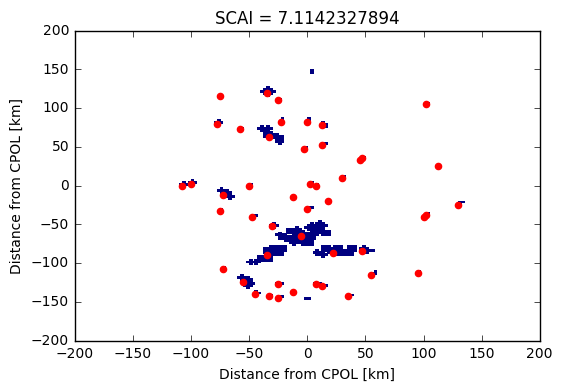

In [25]:
convective = pyart.retrieve.steiner_conv_strat(grid_ss)
x,y = np.meshgrid(grid_ss.x['data'], grid_ss.y['data'])

data_masked = np.ma.masked_where(convective['data'] < 2, convective['data'])
blobs = deepcopy(data_masked)
blobs[~blobs.mask] = 1
blobs[blobs.mask] = 0
blobs.mask = False

# Get locations of blobs

blobs_labels, num_blobs = ndimage.measurements.label(blobs)
print('N = ' + str(num_blobs-2))
locs = ndimage.measurements.center_of_mass(blobs, blobs_labels, range(2, num_blobs))
List = [(elem2, elem1) for elem1, elem2 in locs]
x_points = []
y_points = []
for element in List:  
    x_points.append(x[element[1], element[0]]/1e3)
    y_points.append(y[element[1], element[0]]/1e3)
plt.pcolormesh(x/1e3,y/1e3,data_masked)
plt.xlabel('Distance from CPOL [km]')
plt.ylabel('Distance from CPOL [km]')
plt.scatter(x_points, y_points, color='r')
L = 150.0
a = 1
Nmax = pow((L/a),2)

distances = []
for point1 in List:
    for point2 in List:
        if(point1 != point2):
            d = math.sqrt(pow(point1[0]-point2[0],2) + pow(point1[1]-point2[1],2))
            distances.append(d)
            
n = (num_blobs-2)*(num_blobs-3)/2
d1 = 1/float(n)*np.sum(distances*5)
scai = ((num_blobs-2))/Nmax*d1/(L)*1000
plt.title('SCAI = ' + str(scai))